In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kmodes import KModes

In [54]:
df = pd.read_pickle("cleaned_df.pkl")

In [57]:
def map_education(x):
    if x == "Children":
        return "Children"
    elif x in [
        "Less than 1st grade", "1st 2nd 3rd or 4th grade",
        "5th or 6th grade", "7th and 8th grade",
        "9th grade", "10th grade", "11th grade",
        "12th grade no diploma"
    ]:
        return "Less than HS"
    elif x == "High school graduate":
        return "High School"
    elif x in [
        "Some college but no degree",
        "Associates degree-occup /vocational",
        "Associates degree-academic program"
    ]:
        return "Some College"
    else:
        return "Bachelor+"

df["education_clean"] = df["education"].apply(map_education)

In [58]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[-1, 25, 40, 60, 100],
    labels=[
        "Young (<=25)",
        "Early-career (26-40)",
        "Mid-career (41-60)",
        "Senior (60+)"
    ]
)

In [61]:
def map_marital(x):
    if x == "Never married":
        return "Never married"
    elif "Married" in x:
        return "Married"
    else:
        return "Previously married"

df["marital_clean"] = df["marital stat"].apply(map_marital)

In [62]:
def map_household(x):
    if "Householder" in x:
        return "Householder"
    elif "Spouse" in x:
        return "Spouse"
    elif "Child" in x:
        return "Child"
    else:
        return "Other"

df["household_clean"] = df["detailed household summary in household"].apply(map_household)

In [63]:
df["weeks_group"] = pd.cut(
    df["weeks worked in year"],
    bins=[-1, 0, 25, 48, 52],
    labels=[
        "Not working",
        "Low weeks",
        "Mid weeks",
        "Full year"
    ]
)

In [64]:
def map_class_worker(x):
    if x == "Not in universe":
        return "Not in labor force"
    elif x == "Private":
        return "Private"
    elif "government" in x.lower():
        return "Government"
    elif "self-employed" in x.lower():
        return "Self-employed"
    else:
        return "Other"

df["class_worker_clean"] = df["class of worker"].apply(map_class_worker)

In [65]:
def map_occupation(x):
    x = x.lower()
    
    if "not in universe" in x:
        return "Not in Labor Force"

    elif any(word in x for word in ["professional", "adm support", "executive", "managerial", "technician"]):
        return "White-Collar & Professional"
    
    elif any(word in x for word in ["service", "sales"]):
        return "Service & Sales"

    elif any(word in x for word in ["production", "machine", "handlers", "transportation"]):
        return "Blue-Collar & Labor"
    
    elif "farming" in x or "armed forces" in x:
        return "Primary Industry / Military"
        
    else:
        return "Other"
    
df["occupation_clean"] = df["merge_major occupation code"].apply(map_occupation)

In [93]:
top = [
    "veterans benefits",
    "education_clean",
    "age_group",
    "marital_clean",
    "household_clean",
    "weeks_group",
    "class_worker_clean",
    "occupation_clean"
]

X = df[top].astype(str)

In [94]:
X.head()

,veterans benefits,education_clean,age_group,marital_clean,household_clean,weeks_group,class_worker_clean,occupation_clean
0,2,High School,Senior (60+),Previously married,Other,Not working,Not in labor force,Not in Labor Force
1,2,Some College,Mid-career (41-60),Previously married,Householder,Full year,Self-employed,Blue-Collar & Labor
2,2,Less than HS,Young (<=25),Never married,Child,Not working,Not in labor force,Not in Labor Force
3,0,Children,Young (<=25),Never married,Child,Not working,Not in labor force,Not in Labor Force
4,0,Children,Young (<=25),Never married,Child,Not working,Not in labor force,Not in Labor Force


In [95]:
df[top].isna().sum()

veterans benefits     0
education_clean       0
age_group             0
marital_clean         0
household_clean       0
weeks_group           0
class_worker_clean    0
occupation_clean      0
dtype: int64

In [96]:
summary_dict = {}

for col in top:
    summary_dict[col] = (
        df[col]
        .value_counts(normalize=True)
        .mul(100)
        .round(2)
    )

summary_dict

{'veterans benefits': veterans benefits
 2    75.24
 0    23.76
 1     0.99
 Name: proportion, dtype: float64,
 'education_clean': education_clean
 High School     24.26
 Children        23.77
 Some College    18.82
 Less than HS    18.39
 Bachelor+       14.77
 Name: proportion, dtype: float64,
 'age_group': age_group
 Young (<=25)            38.39
 Early-career (26-40)    23.92
 Mid-career (41-60)      22.46
 Senior (60+)            15.23
 Name: proportion, dtype: float64,
 'marital_clean': marital_clean
 Never married         43.35
 Married               43.31
 Previously married    13.35
 Name: proportion, dtype: float64,
 'household_clean': household_clean
 Householder    37.83
 Child          32.53
 Spouse         20.90
 Other           8.74
 Name: proportion, dtype: float64,
 'weeks_group': weeks_group
 Not working    48.11
 Full year      37.06
 Mid weeks       8.34
 Low weeks       6.49
 Name: proportion, dtype: float64,
 'class_worker_clean': class_worker_clean
 Not in labor 

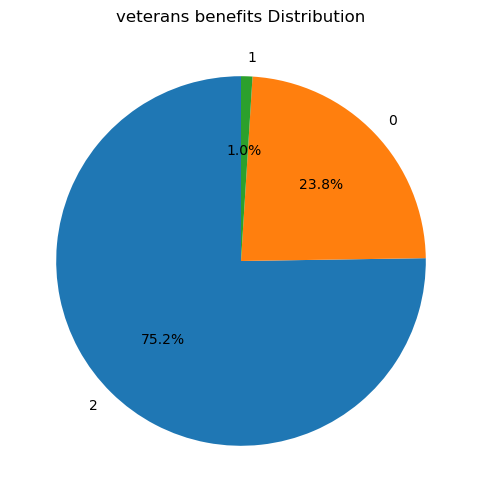

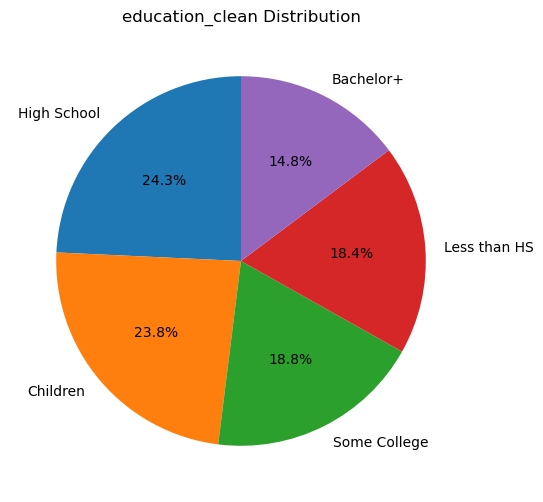

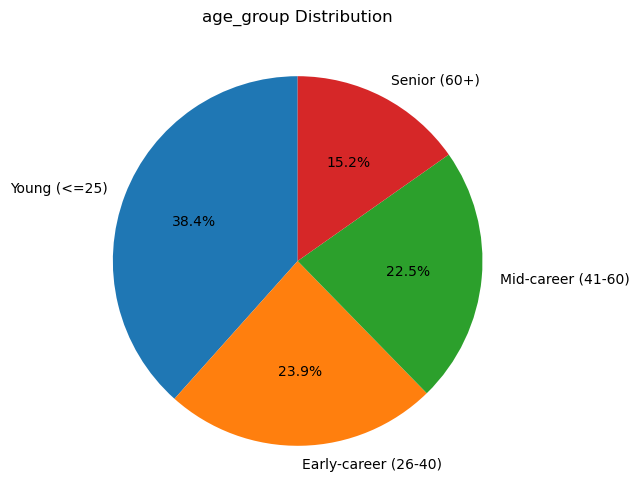

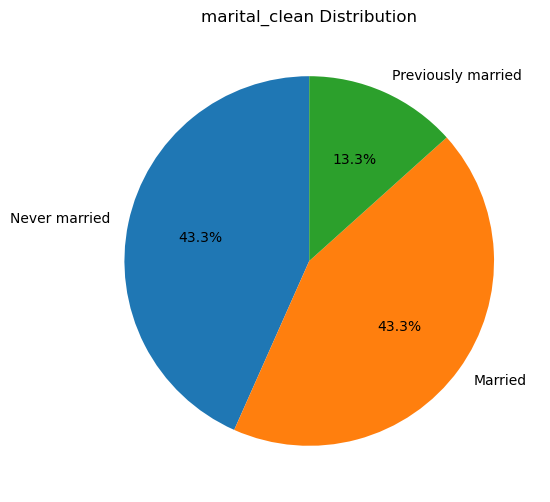

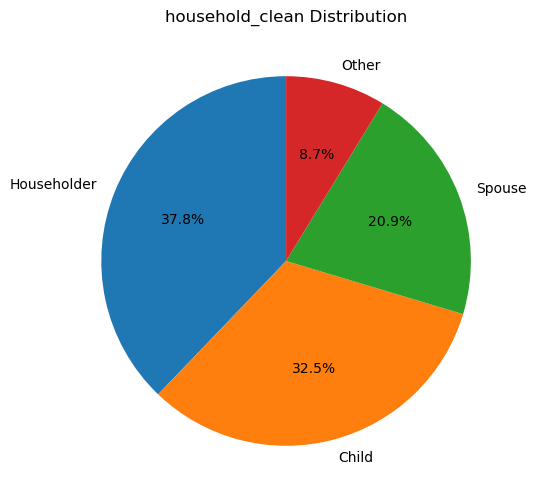

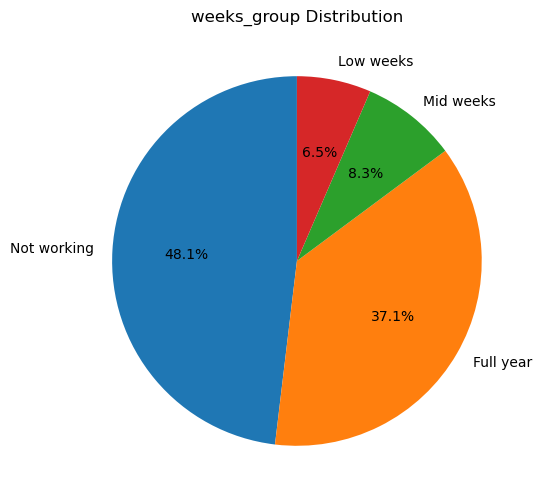

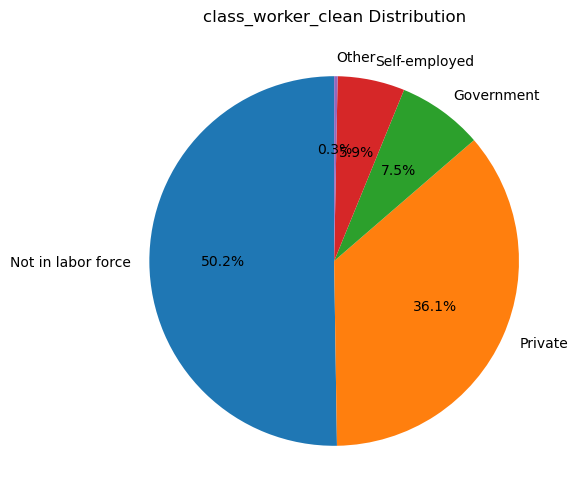

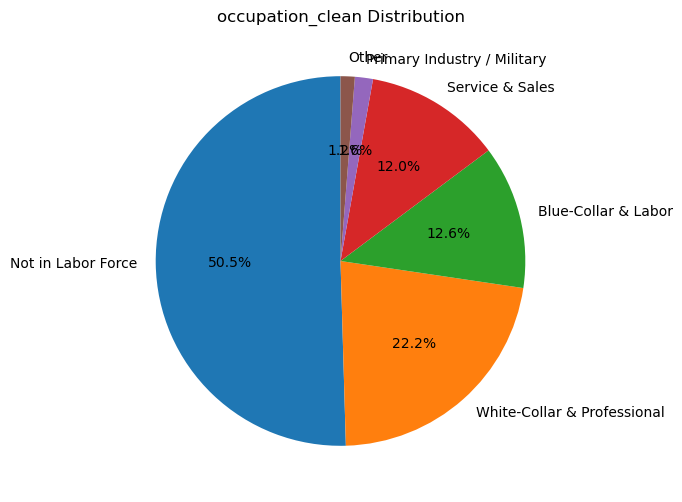

In [97]:
for col in top:
    counts = df[col].value_counts()
    
    plt.figure(figsize=(6,6))
    plt.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"{col} Distribution")
    plt.show()

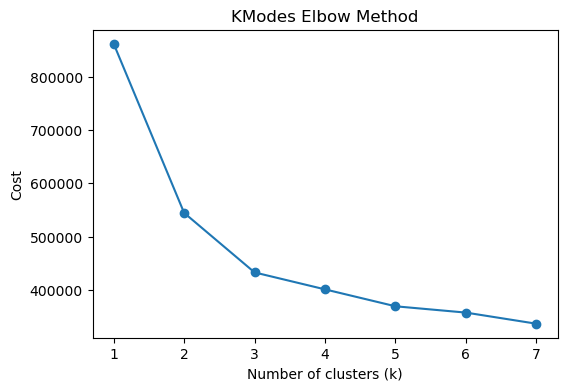

In [98]:
cost = []
K_range = range(1, 8)

for k in K_range:
    km = KModes(n_clusters=k, init='Cao', n_init=1, verbose=0, random_state=42)
    km.fit(X)
    cost.append(km.cost_)

plt.figure(figsize=(6,4))
plt.plot(K_range, cost, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Cost")
plt.title("KModes Elbow Method")
plt.show()

In [99]:
k = 3

km_final = KModes(
    n_clusters=k,
    init='Cao',
    n_init=1,        
    verbose=1,
    random_state=42
)

clusters = km_final.fit_predict(X)

df["cluster"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 48737, cost: 432559.0
Run 1, iteration: 2/100, moves: 10826, cost: 432559.0


In [100]:
clusterCentroidsDf = pd.DataFrame(
    km_final.cluster_centroids_,
    columns=X.columns
)

clusterCentroidsDf

,veterans benefits,education_clean,age_group,marital_clean,household_clean,weeks_group,class_worker_clean,occupation_clean
0,0,Children,Young (<=25),Never married,Child,Not working,Not in labor force,Not in Labor Force
1,2,High School,Early-career (26-40),Married,Householder,Full year,Private,White-Collar & Professional
2,2,Less than HS,Senior (60+),Married,Householder,Not working,Not in labor force,Not in Labor Force


In [101]:
k = 4

km_final = KModes(
    n_clusters=k,
    init='Cao',
    n_init=1,        
    verbose=1,
    random_state=42
)

clusters = km_final.fit_predict(X)

df["cluster"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 48784, cost: 400724.0
Run 1, iteration: 2/100, moves: 6814, cost: 400724.0


In [102]:
clusterCentroidsDf = pd.DataFrame(
    km_final.cluster_centroids_,
    columns=X.columns
)

clusterCentroidsDf

,veterans benefits,education_clean,age_group,marital_clean,household_clean,weeks_group,class_worker_clean,occupation_clean
0,0,Children,Young (<=25),Never married,Child,Not working,Not in labor force,Not in Labor Force
1,2,Some College,Early-career (26-40),Married,Householder,Full year,Private,White-Collar & Professional
2,2,Less than HS,Senior (60+),Married,Householder,Not working,Not in labor force,Not in Labor Force
3,2,Bachelor+,Mid-career (41-60),Married,Householder,Full year,Private,Blue-Collar & Labor


In [103]:
df["cluster"].value_counts(normalize=True)

cluster
0    0.329200
1    0.322083
2    0.209901
3    0.138816
Name: proportion, dtype: float64

In [105]:
for col in top:
    print("\n====", col, "====")
    print(df.groupby("cluster")[col].value_counts(normalize=True))


==== veterans benefits ====
cluster  veterans benefits
0        0                    0.721785
         2                    0.276830
         1                    0.001385
1        2                    0.993542
         1                    0.006458
         0                    0.000000
2        2                    0.972087
         1                    0.027913
         0                    0.000000
3        2                    0.988844
         1                    0.011156
         0                    0.000000
Name: proportion, dtype: float64

==== education_clean ====
cluster  education_clean
0        Children           0.721968
         Less than HS       0.167395
         Some College       0.051094
         High School        0.049054
         Bachelor+          0.010490
1        Some College       0.396309
         High School        0.327000
         Bachelor+          0.191930
         Less than HS       0.084761
2        Less than HS       0.375167
         High School 

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


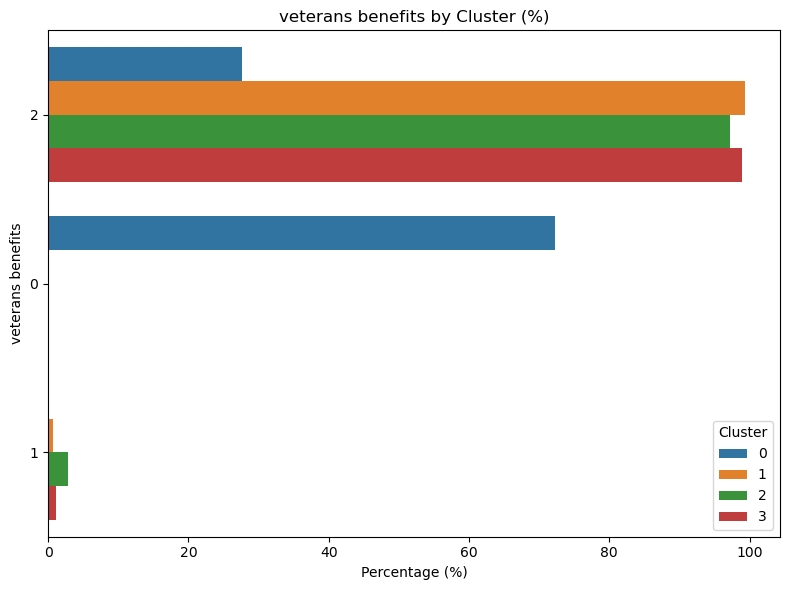

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


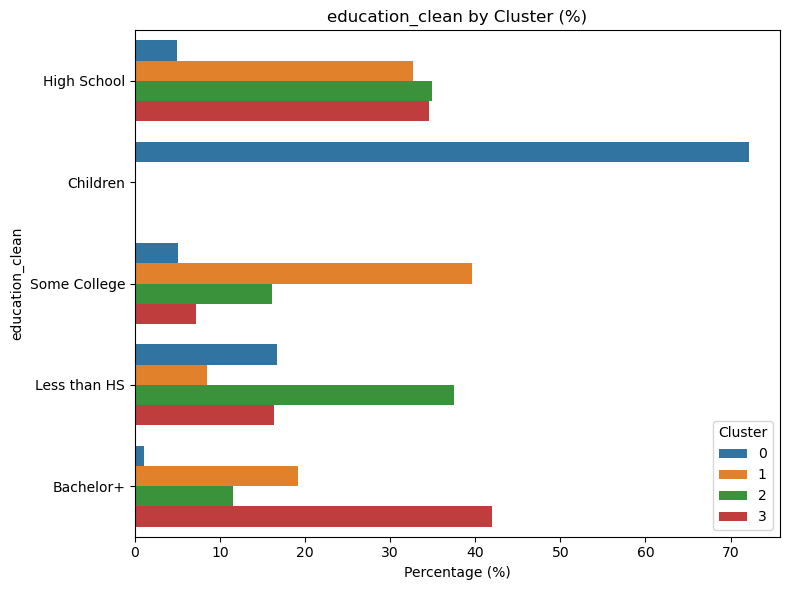

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


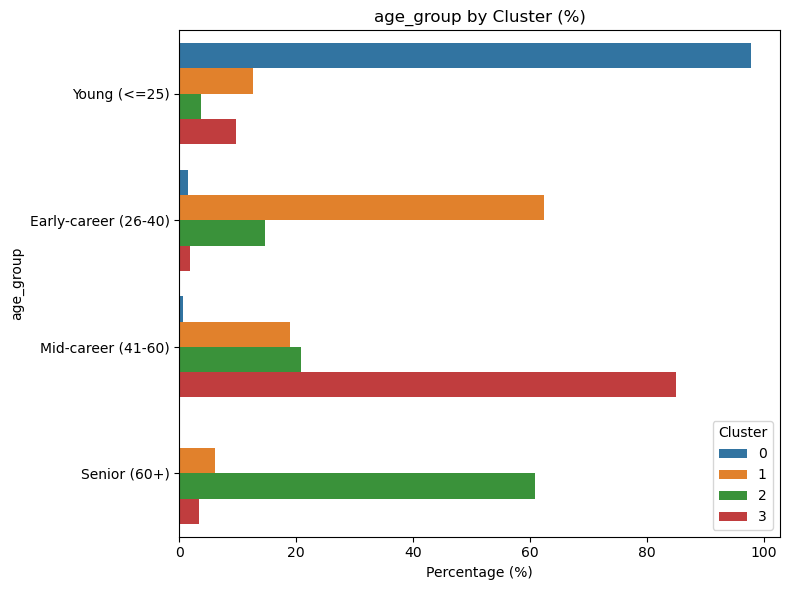

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


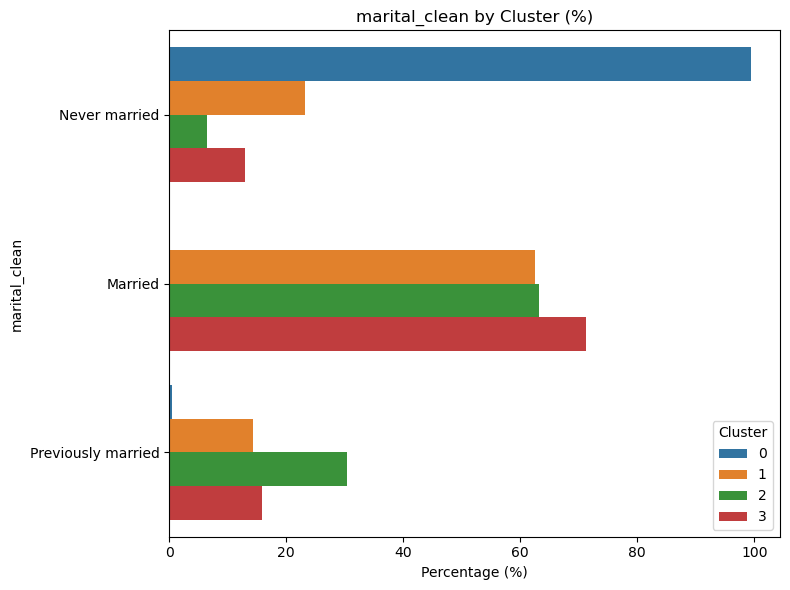

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


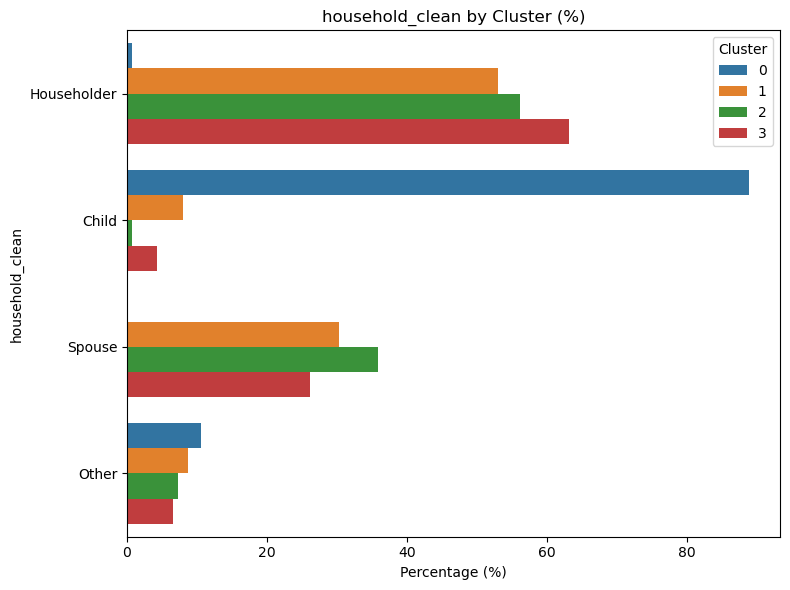

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


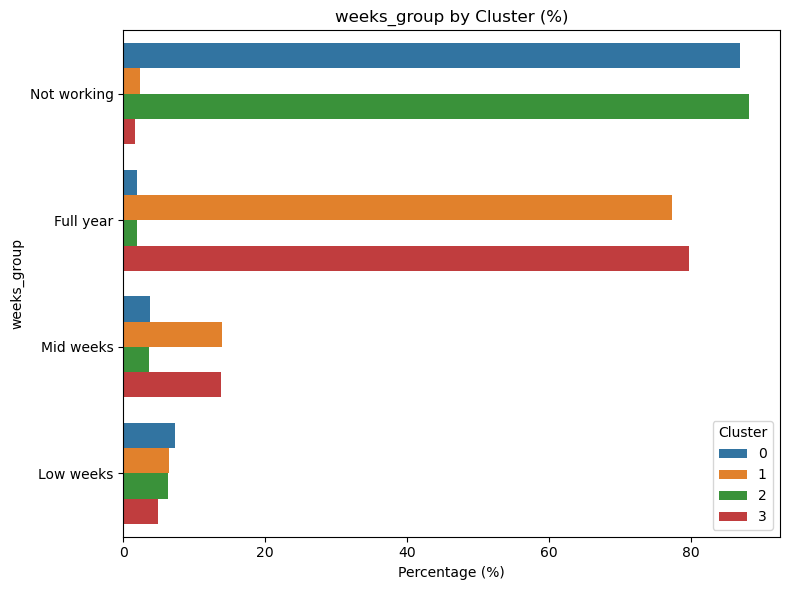

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


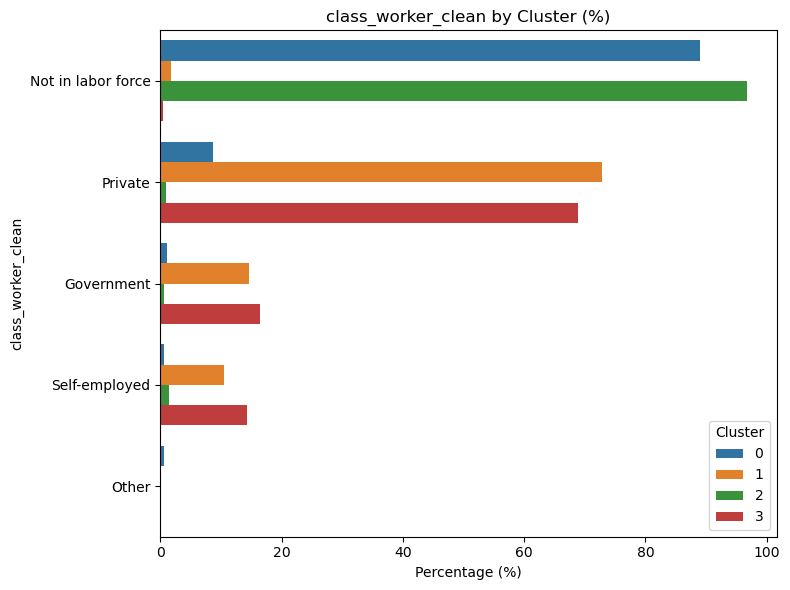

/var/folders/bq/v2143g0x2_9c04yrpv3m7vbc0000gn/T/ipykernel_59421/1638822423.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


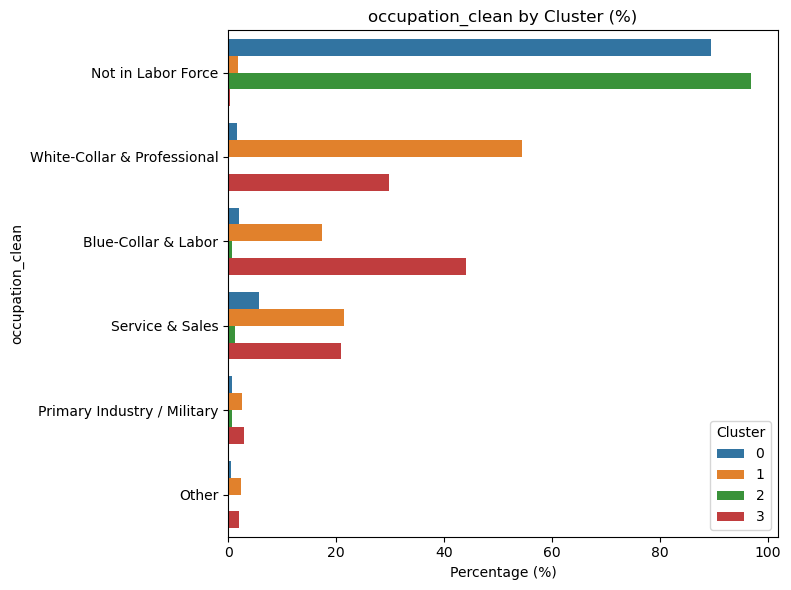

In [110]:
palette = sns.color_palette("tab10")

for col in top:
    
    temp = (
        df.groupby("cluster")[col]
        .value_counts(normalize=True)
        .mul(100)
        .rename("percentage")
        .reset_index()
    )
    
    order = (
        df[col]
        .value_counts(normalize=True)
        .sort_values(ascending=False)
        .index
    )
    
    plt.figure(figsize=(8,6))
    
    sns.barplot(
        data=temp,
        y=col,
        x="percentage",
        hue="cluster",
        order=order,
        palette=palette
    )
    
    plt.title(f"{col} by Cluster (%)")
    plt.xlabel("Percentage (%)")
    plt.ylabel(col)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [114]:
cluster_names = {
    0: "Young Dependents",
    1: "Early-Career Private Workers",
    2: "Retired Seniors",
    3: "Mid-Career Working Adults"
}

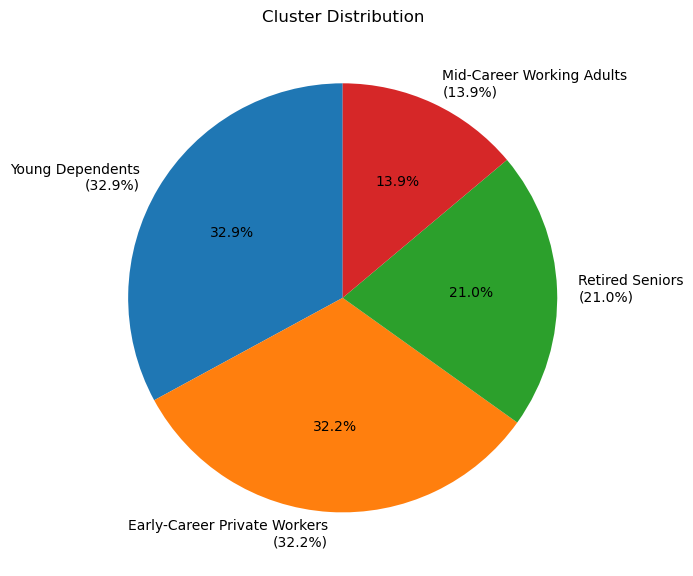

In [115]:
cluster_pct = df["cluster"].value_counts(normalize=True).sort_index()

labels = [
    f"{cluster_names[i]}\n({cluster_pct[i]*100:.1f}%)"
    for i in cluster_pct.index
]

plt.figure(figsize=(7,7))

plt.pie(
    cluster_pct,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
)

plt.title("Cluster Distribution")
plt.tight_layout()
plt.show()

In [113]:
income_table = (
    df.groupby("cluster")["income_binary"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .unstack()
)

income_table.columns = ["income_0_%", "income_1_%"]

income_table

,income_0_%,income_1_%
cluster,,
0,99.94,0.06
1,90.28,9.72
2,98.05,1.95
3,80.93,19.07
